# Time-Domain Response of a Lossy Waveguide

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.constants as sc
from scipy.signal.windows import tukey

# CZT package
import czt

# https://scikit-rf.readthedocs.io/
from skrf import Frequency, RectangularWaveguide

# https://github.com/garrettj403/SciencePlots
import scienceplots
plt.style.use(['science', 'notebook'])

In [3]:
def db20(value):
    """Convert linear voltage-like value to dB."""
    return 20 * np.log10(np.abs(value))

In [4]:
# Define frequency sweep
freq  = Frequency(250, 400, 15001, 'ghz')
print("Frequency sweep: ", freq)
print("Frequency step:   {:.1f} MHz".format((freq.f[1] - freq.f[0]) / sc.mega))

Frequency sweep:  250.0-400.0 GHz, 15001 pts
Frequency step:   10.0 MHz


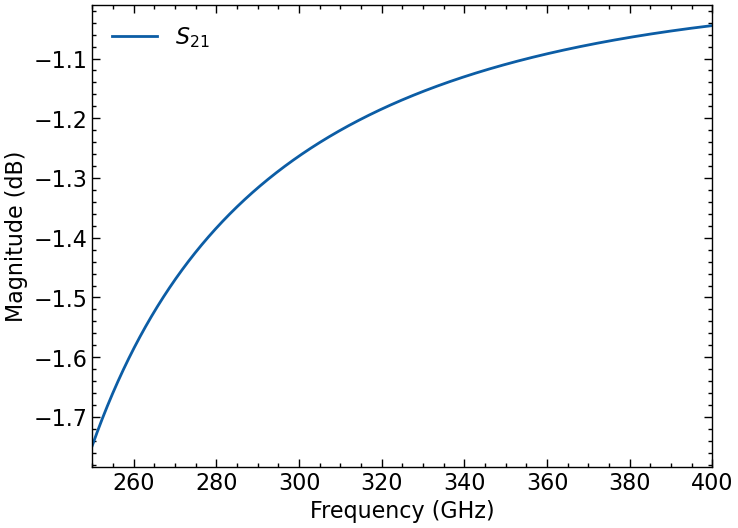

In [5]:
# Create gold-plated WR-2.8 waveguide
wr2p8 = RectangularWaveguide(freq.copy(), a=28*sc.mil, b=14*sc.mil, rho='Al')

# Create 2 inch long waveguide
waveguide = wr2p8.line(2, unit='in')
waveguide.name = '2" long WR-2.8 waveguide'

# Unpack 
f = waveguide.f.copy()
s21f = waveguide.s[:,1,0].copy()

# Plot S-parameters
plt.figure()
plt.plot(f/sc.giga, db20(s21f), label=r"$S_{21}$")
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Magnitude (dB)")
plt.legend();

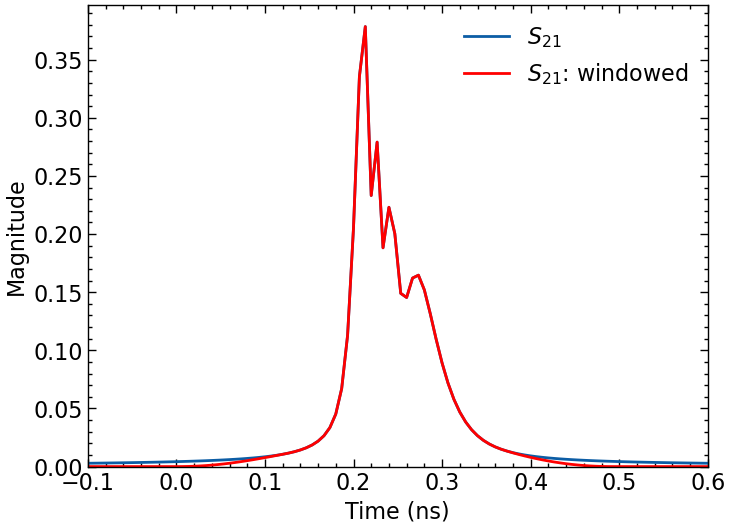

In [6]:
# Calculate time-domain response
t, s21t = czt.freq2time(f, s21f)

# Apply window (not really needed in this case, but used as a demonstration)
t1, t2 = 0*sc.nano, 0.5*sc.nano
idx1, idx2 = np.abs(t - t1).argmin(), np.abs(t - t2).argmin()
window = np.r_[np.zeros(idx1), 
               tukey(idx2-idx1, 0.5),
               np.zeros(len(t)-idx2)]
s21tw = s21t * window

# Plot time-domain response
plt.figure()
plt.plot(t/sc.nano, np.abs(s21t*np.hanning(len(s21t))), label=r'$S_{21}$')
plt.plot(t/sc.nano, np.abs(s21tw), 'r', label=r'$S_{21}$: windowed')
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("Time (ns)")
plt.ylabel("Magnitude")
plt.xlim([-0.1, 0.6])
plt.ylim(ymin=0)
plt.legend();

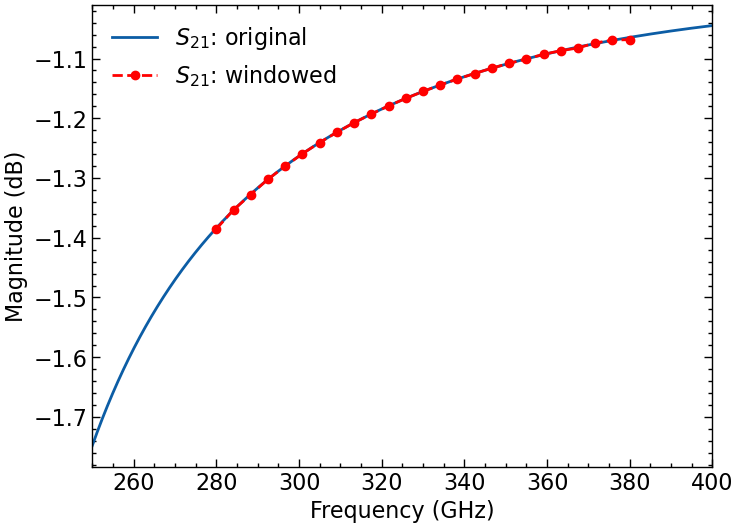

In [7]:
# Recover frequency-domain using arbitrary frequency sweep
f_new = np.linspace(280, 380, 25) * sc.giga
f_new, s21f_twindow = czt.time2freq(t, s21tw, f_new)

# Plot frequency-domain
plt.figure()
plt.plot(f/sc.giga, db20(s21f), label=r"$S_{21}$: original")
plt.plot(f_new/sc.giga, db20(s21f_twindow), 'ro--', label='$S_{21}$: windowed')
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Magnitude (dB)")
plt.xlim([250, 400])
plt.legend();